In [287]:
def importAsDF(files, de):
    startdfs = [0 for x in range(len(files))]

    #import txt files as dataframes
    for i in range(len(files)):
        df= pd.read_csv(files[i], delimiter = "\t", header = None)
        startdfs[i]=df
    #create a more sorted df
    index = []
    lang_dict = {}
    job_dict = {}
    company_dict = {}
    descr_dict = {}

    for j in range(len(startdfs)):

        df = startdfs[j]
        index += [j]

        if de:
            lang ="de"
        else:
            lang= "en"
        lang_dict[j]= lang;

        job = df.iloc[0,0]
        job_dict[j]= job

        company = df.iloc[1,0]
        company_dict[j]= company;

        descr = df.iloc[2,0]
        for i in range(3,len(df.index)):
            descr = descr + " "+ df.iloc[i,0].strip("◾")
        descr_dict[j] = descr

    lang_series = pd.Series(lang_dict)
    job_series = pd.Series(job_dict)
    company_series = pd.Series(company_dict)
    descr_series = pd.Series(descr_dict)

    df = pd.DataFrame({'job':job_series, 'company':company_series, 'description':descr_series, 'language':lang_series,})
    return df

In [288]:
def getjobdescriptions(df):
    #get all descriptions
    descrstr = ""
    for i in range(len(df)):
        descrstr =descrstr +" "+ df.iloc[i,2].replace("◾", "").replace("()", "").replace(")", "").replace("[", "").replace("]", "")
    return descrstr

In [289]:
def getjobdescriptionsaslist(df):
    #get all descriptions
    descrstr = []
    for i in range(len(df)):
        descrstr += [df.iloc[i,2].lower().replace("◾", "").replace("()", "").replace(")", "").replace("[", "").replace("]", "")]
    return descrstr

In [290]:
#de: True -> german, False -> English
def spacy(descrstr, de):
    #let the spacy magic begin ^^
    import spacy
    from spacy.tokens import Doc
    from spacy.lang.de import German
    from spacy.lang.en import English
    if(de):
        nlp = spacy.load("de_core_news_sm")
    else:
        nlp = spacy.load("en_core_web_sm") #TODO: find english pack
    doc = nlp(descrstr)

    #Matching
    from spacy.matcher import Matcher

    #get double proper nouns
    matcher = Matcher(nlp.vocab)
    pattern = [{"POS": "PROPN"}, {"POS": "PROPN"}]
    #pattern0 = [{"POS": "PROPN"}]
    #matcher.add("pat0", [pattern0])
    matcher.add("pat", [pattern])
    matches = matcher(doc)

    results =  [doc[start:end].text for match_id, start, end in matches]
    #put double proper nouns in dict and count them
    pnounscount = {}
    pnouns = {}
    index = []
    
    for result in results:
            if result in pnounscount:
                pnounscount[result] = pnounscount[result]+1
            else:
                pnounscount[result] = 1
                pnouns[result] = result
                index +=[result]
                
        #get single proper nouns (matcher seems to not have the functionallity to exclude the ones already counted in the double ones) 
    for i in range(len(doc)):
        token = doc[i]
        addtoken = False
        #first Token has only a right neighbor
        if i == 0:
            rNbor = token.nbor(1)
            if token.pos_ == 'PROPN' and rNbor.pos_ != 'PROPN' and rNbor.pos_ != 'NOUN':
                addtoken = True
        #last Token has only a left neighbor
        elif i == len(doc) -1:
            lNbor = token.nbor(-1)
            if lNbor.pos_ != 'PROPN'and lNbor.pos_ != 'NOUN' and token.pos_ == 'PROPN':
                addtoken = True
        #default Tokens have a right and a left neighbor
        else:
            rNbor = token.nbor(1)
            lNbor = token.nbor(-1)
            if lNbor.pos_ != 'PROPN' and lNbor.pos_ != 'NOUN' and token.pos_ == 'PROPN' and rNbor.pos_ != 'PROPN' and rNbor.pos_ != 'NOUN':
                addtoken = True

        if addtoken:
            if token.text in pnounscount:
                pnounscount[token.text] = pnounscount[token.text]+1
            else:
                pnounscount[token.text] = 1
                pnouns[token.text] = token.text
                index +=[token.text]
            addtoken = False
            
    pncount = pd.Series(pnounscount)
    pn = pd.Series(pnouns)
    df = pd.DataFrame({'count':pncount, 'term':pn}, index = index)
    df = df.sort_values(by = 'count', ascending = False)
            
    return df

In [291]:
def plot(df):
    #Plot 
    import matplotlib.pyplot as plt
    plt.figure()
    plt.ylabel('Anzahl der Nennungen')
    plt.xlabel('Begriff')
    df['count'].plot(kind='bar')

In [292]:
def getDF(files, de): 
    df1 = importAsDF(files,de)
    descr = getjobdescriptions(df1)
    df = spacy(descr, de)
    return df

In [294]:
#find files
import pandas as pd
import glob

files = glob.glob(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\Jobs DE\*.txt")
df = getDF(files, True)

filesen = glob.glob(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\Jobs EN\*.txt")
dfen = getDF(filesen, False)

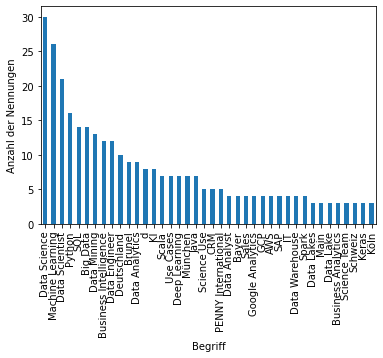

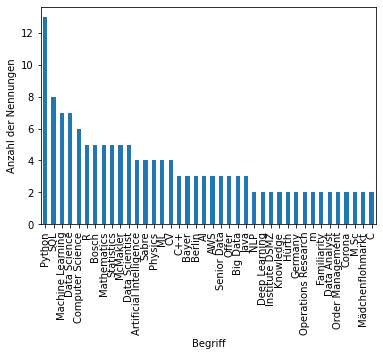

In [295]:
plot(df[:40])
plot(dfen[:40])

In [296]:
def cossim(vec, doc0, doc1):    
    #Ähnlichkeiten zwischen 2 Dokumenten
    from sklearn.metrics.pairwise import cosine_similarity
    
    vec1 = np.array(vec[doc0].toarray())
    vec2 = np.array(vec[doc1].toarray())
    sim = (cosine_similarity(vec1, vec2))
    return sim

In [297]:
def ttm(vector):   
    #Ähnlichkeiten zwischen den Begriffen (Begriff-Begriffsmatrix) mit CountVectorizer
    #similaritys between terms in a matrix
    from sklearn.metrics.pairwise import cosine_similarity
    vec = vector.toarray()
    vec = vec.transpose()
    
    #the Terms axis is 0
    dim0 = vec.shape[0]
    termtermmat = np.empty([dim0,dim0]) 

    for x in range(dim0):
        for y in range(dim0):
            termtermmat[x,y]= cosine_similarity([vec[x]],[vec[y]])

    return termtermmat

In [298]:
def getterms(df):
    terms = []
    for i in range(len(df)):
        terms += [df.iloc[i,1].lower()]
    return terms

In [299]:
def nowhitespace(textlist):
    for i in range(len(textlist)):
        textlist[i] = textlist[i].replace(" ", "")
    return textlist

In [300]:
def replacespace(docs, termsorg,terms):
    for i in range(len(docs)):
        for t in range(len(terms)):
            docs[i] = docs[i].replace(termsorg[t].lower(), terms[t].lower())
            #print(i, termsorg[t].lower(),terms[t].lower() )
    return(docs)

In [316]:
import numpy as np

nrterms = 30
#to have that exact number

#We will have to ged rid of those whitespaces, because otherwise those conjoined word would have been counted as 2 single words
termsorg = getterms(df[:nrterms])
terms = nowhitespace(termsorg.copy())

df1 = importAsDF(files,True)
docs = getjobdescriptionsaslist(df1)
#same with the doc text: at least our word have to be without whitespaces now
docs = replacespace(docs, termsorg,terms)

#print(text)

In [308]:
#get Count-Vectorizer - Term-Document-Matrix
from sklearn.feature_extraction.text import CountVectorizer
cvectorizer = CountVectorizer()
cvectorizer.fit(terms)
cvocab = cvectorizer.vocabulary_
cvec = cvectorizer.transform(docs)

#get Tfidf-Vectorizer - Term-Document-Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tvectorizer = TfidfVectorizer()
tvectorizer.fit(terms)
tvocab = tvectorizer.vocabulary_
tvec = tvectorizer.transform(docs)

In [309]:
#compare docs
doc0 = 2
doc1 = 7
sim0 = cossim(cvec,doc0,doc1)
sim1 = cossim(tvec,doc0,doc1)
print(sim0,sim1)

[[0.]] [[0.]]


In [310]:
#compare terms
#more than those first terms, because those term consisted of conjoined words whoom are now singled out
#dont choose too many terms for this
tttm = ttm(tvec)

In [311]:
name = tvectorizer.get_feature_names()
name = replacespace(name, terms, termsorg)
    
    
print(name)

['aws', 'bayer', 'big data', 'brunel', 'business intelligence', 'crm', 'data analyst', 'data analytics', 'data engineer', 'data mining', 'data science', 'data scientist', 'deep learning', 'deutschland', 'gcp', 'google analytics', 'it', 'java', 'ki', 'machine learning', 'münchen', 'penny international', 'python', 'sales', 'sap', 'scala', 'science use', 'sql', 'use cases']


In [312]:
import pandas as pd
dfmat ={}
for i in range(len(name)):
    dfmat[name[i]]=tttm[i]

ttdf = pd.DataFrame(dfmat, index = name)
print(ttdf)

                            aws     bayer  big data    brunel  \
aws                    1.000000  0.000000  0.186584  0.000000   
bayer                  0.000000  1.000000  0.000000  0.000000   
big data               0.186584  0.000000  1.000000  0.000000   
brunel                 0.000000  0.000000  0.000000  1.000000   
business intelligence  0.000000  0.000000  0.197587  0.173527   
crm                    0.119146  0.176227  0.173795  0.000000   
data analyst           0.000000  0.000000  0.138779  0.074482   
data analytics         0.063828  0.000000  0.184102  0.000000   
data engineer          0.546322  0.000000  0.070746  0.000000   
data mining            0.062397  0.000000  0.258044  0.000000   
data science           0.163446  0.000000  0.309455  0.000000   
data scientist         0.126523  0.097143  0.157216  0.066020   
deep learning          0.048866  0.000000  0.000000  0.000000   
deutschland            0.000000  0.000000  0.108616  0.495248   
gcp                    0.